# Librerías necesarias

In [ ]:
!pip install -r requirements.txt
!pip install utils.py

In [ ]:
!pip install unzip
!unzip corpusCine.zip

In [3]:

from utils import load_cinema_reviews

import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
from stop_words import get_stop_words # Preprocesado
import unicodedata # Preprocesado
import re # Preprocesado


from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte

import matplotlib.pyplot as plt

# Carga de datos

In [4]:
# Path al directorio donde tenemos los datasets con las reviews
# ¡Descomprimir antes!
datasets_path = './'
corpus_cine_folder = 'corpusCine'

In [5]:
reviews_dict = load_cinema_reviews(datasets_path, corpus_cine_folder)

In [6]:
reviews_dict.get(10)

{'author': 'Javier Moreno',
 'title': 'Harry poter y el caliz de fuego',
 'sentiment': '4',
 'summary': 'Interesante adaptación de la novela de Rowling',
 'review_text': 'No. Esta vez no voy a usar una película como pretexto para exponer mis ideas o pensamientos mas dementes/racionales/insensatos. Esta vez, y lo juro ante el sagrado Necronomicón de Lovecraft, pienso hablar de la película en si (por primera vez y esperando que no sirva de precedente), aunque creo que es evidente que prefiero que una película me haga reflexionar sobre cualquier aspecto que en ella se de cita. Quizas algún dia hable sobre todo lo que significa la saga de novelas de Rowling (anda que no tengo cosas de las que hablar) desde una perspectiva menos mitológica y mas profunda.Parto de la base de que soy un autentico fan de los libros, los adoro, me parecen de lo mejorcito que ha salido en fantasia, con un personaje principal realmente interesante y atormentado a todos los niveles por todo lo que su no-existencia

In [7]:
reviews_text = []
reviews_sentiment = []

for review in reviews_dict.values():
    reviews_text.append(review.get('review_text'))
    reviews_sentiment.append(review.get('sentiment'))

df = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_sentiment
})
df.dropna(subset=['review', 'sentiment'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Análisis Exploratorio

In [ ]:
df.head()

,review,sentiment
0,Cada vez me gusta menos el cine de masas. Las ...,1
1,"El otro dia fui a ver ""la de los sioux"" como d...",3
2,"Es que no la cagan en ninguna, todas las pelis...",5
3,Es un dolor esto del cine. Yo ya voy con miedo...,2
4,"Tras una insufrible primera media hora, la cas...",2


In [8]:
splitted_reviews = df['review'].str.lower().str.split()

De cara a una aproximación rápida, únicamente convertimos a minúsculas y tokenizamos por espacios.

In [9]:
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

In [10]:
vocabulary_ = Counter(words)

Número de tokens que componen el vocabulario 

In [ ]:
len(vocabulary_)

139838

### Distribución de reviews por sentimiento

Podemos que la mayor parte de reviews se corresponde con aquellas con sentimiento 2,3 y 4

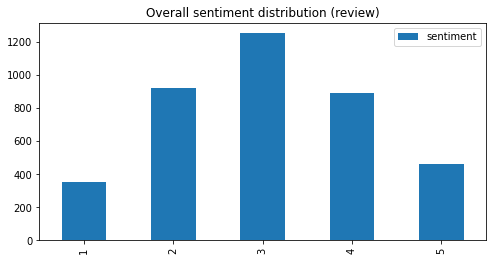

In [ ]:
aux_df = pd.DataFrame(df['sentiment'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

In [29]:
def label_sentiment(row):
    if int(row['sentiment']) < 3:
        return 1
    else:
        return 0

In [30]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [ ]:
df.head()

,review,sentiment,sentiment_label
0,Cada vez me gusta menos el cine de masas. Las ...,1,1
1,"El otro dia fui a ver ""la de los sioux"" como d...",3,0
2,"Es que no la cagan en ninguna, todas las pelis...",5,0
3,Es un dolor esto del cine. Yo ya voy con miedo...,2,1
4,"Tras una insufrible primera media hora, la cas...",2,1


Al no haber podido seleccionar de manera estratificada las reviews deberíamos tener 2500 reviews negativas y 1500 positivas .

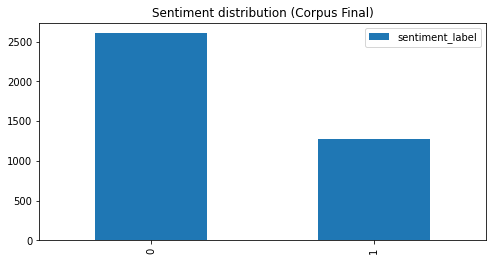

In [ ]:
aux_df = pd.DataFrame(df['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

# N-grams más frecuentes

Realizamos el cálculo de los 2-gramas y 3-grams directamente de la Series de pandas con todas las palabras. Al estar interesados únicamente en los más frecuentes no habrá problemas al combinar el último token de una review con el token inicial de la siguiente. Esto nos permite agilizar el cómputo en esta etapa previa de exploración.

In [ ]:
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

In [ ]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

Parece evidente que la eliminación de stopwords es necesaria.

In [ ]:
bigrams_freq_.most_common(10)

[(('de', 'la'), 13931),
 (('en', 'la'), 6660),
 (('en', 'el'), 6648),
 (('de', 'los'), 6645),
 (('a', 'la'), 6142),
 (('que', 'se'), 5032),
 (('lo', 'que'), 4749),
 (('que', 'no'), 3911),
 (('de', 'un'), 3737),
 (('de', 'las'), 3535)]

In [ ]:
trigrams_freq_.most_common(10)


[(('uno', 'de', 'los'), 978),
 (('una', 'de', 'las'), 790),
 (('en', 'la', 'que'), 772),
 (('en', 'el', 'que'), 742),
 (('de', 'la', 'película'), 722),
 (('de', 'lo', 'que'), 685),
 (('a', 'pesar', 'de'), 633),
 (('y', 'es', 'que'), 540),
 (('es', 'una', 'película'), 524),
 (('la', 'historia', 'de'), 498)]

# Preprocesado

### Función de preprocesado de texto

Implementamos una función de preprocesado de texto que nos permitirá estandarizar el formato de las reviews a la entrada. Se realizan los siguientes pasos:

* Eliminar tildes
* Eliminar símbolos
* Eliminar todo carácter que no sea una letra
* Elimar stopwords

In [20]:
def sentence_normalization(sentence):
    sentence = unicodedata.normalize('NFKD', sentence).lower().encode('ascii', errors='ignore').decode('utf-8')
    sentence = re.sub(' +', ' ', ' '.join([word if word.isalpha() else '' for word in sentence.split()])).strip()
    return sentence

In [21]:
def remove_stopwords(sentence, sw_list):
    sentence = ' '.join([word for word in sentence.split() if word not in sw_list])
    return sentence

In [22]:
sw_list = get_stop_words('es')

In [23]:
def process_reviews(reviews, sw_list):
    processed_sentences = []
    for sent in df['review']:
        if not sent != sent:  # check if sent is not nan
            sent = sentence_normalization(sent)
            sent = remove_stopwords(sent, sw_list)
            processed_sentences.append(sent)
        else:
            processed_sentences.append('None')
    return processed_sentences

In [24]:
processed_reviews = process_reviews(df['review'], sw_list)

Vemos lo que conseguimos con nuestro preprocesado

In [25]:
print('Review original: {}'.format(df['review'].values[0]))
print('Review procesada: {}'.format(processed_reviews[0]))

Review original: Cada vez me gusta menos el cine de masas. Las peliculas que ven todo el mundo me parecen cada vez mas coñazo y mas insufribles. No se porqué pero siempre el prota es tonto del culo y tiene suerte, y al final de la peli, cuando ha logrado vencer al mal, se convierte en listo, y las chorradas que hacia al comienzo de la pelicula se esfuman como por arte de magia. Se vuelve maduro e inteligente.Esta peli de Spielberg es mas de lo mismo, huir y huir y que no le den ni un solo tiro. Además el cabron ha metido a un par de actores que es como para echarles de comer aparte. La niña, una vieja metida en el cuerpo de una niña, porque solo hay que verle hablar (en version original claro) para darse cuenta que estamos ante uno de los grandes freaks del cine. Se creeran que hace gracia la nena cuando habla igual que su puta madre, pero a mi me causa pavor. Ver a una cria que habla como una persona madura es algo horroroso. Los niños son niños y verlos fuera de su rol asusta.Luego e

In [26]:
df.loc[:, 'processedReview'] = processed_reviews

In [27]:
df['processedReview'] = df['processedReview'].replace('', np.nan)
df = df.dropna(subset=['processedReview'])

# Modelado

# Separamos en conjunto de train y test

Creamos los conjuntos de entrenamiento (75% del total) y test (25%).

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    df['processedReview'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [ ]:
X_train.iloc[:10]

1924    zhang yimou poeta director chino firmo filmo l...
3250    aventuras amorosas joven molire segundo largom...
1620    cientifismo naturalista genero cinematografico...
907     quiza esperaba critica mas demoledora sistema ...
1864    colateral michael mann desnuda claridad vicios...
3007    gracia querejeta directora tomada medida debid...
1583    extranas peliculas empiezan importandome pepin...
370     suele ocurrir alguien pone expectativas altas ...
2045    vivian vive trabaja tienda chocolates aficione...
3601    filmes pasan ser culto hecho concreto menos ca...
Name: processedReview, dtype: object

In [ ]:
y_train.iloc[:10]

1924    0
3250    0
1620    1
907     1
1864    0
3007    0
1583    0
370     0
2045    1
3601    1
Name: sentiment_label, dtype: int64

# Extracción de features

In [ ]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3, strip_accents='ascii')

La extracción de características será realizada con la clase **TfidfVectorizerde sklearn**. Los parámetros y valores que se definen son:

* ngram_range: (1, 3), de cara a codificar de manera más rica el contexto de cada palabra se trabajará con 1-grams, 2-grams y 3-grams.
* max_df: 0.95, al haber realizado una etapa de preprocesado en la que se eliminan stopwords y se lemmatiza no se requiere volver a eliminar tokens muy frecuentes.
* min_df: 3, tokens con una frecuencia baja se interpretan como outliers, posiblemente typos u otro tipo de errores.
* max_features: 2500, al trabajar con 1-gram, 2-grams y 3-grams seleccionamos un tamaño de vocabulario grande que nos permita contemplar los top n-grams más representativos.

In [ ]:
print(list(cv.vocabulary_.items())[:20])

[('director', 683), ('alla', 87), ('primeros', 1826), ('ahora', 72), ('visual', 2465), ('maestro', 1358), ('cuyo', 552), ('talento', 2246), ('consiste', 447), ('ejercicio', 749), ('bajo', 202), ('forma', 970), ('entender', 790), ('cine', 354), ('mas', 1397), ('puro', 1897), ('estilo', 856), ('precisa', 1801), ('tan', 2251), ('traje', 2339)]


In [ ]:
print(len(cv.vocabulary_))

2500


## TF-IDF scores del training set y test set

In [ ]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## Score IDF de algunas palabras

In [ ]:
words_example = [
    'cine',
    'pelicula',
    'muy',
    'y',
    'de',
    'que',
    'potter',
    'mala',
    'aburrimiento',
    'sorprendente',
    'aburrir',
    'ausdf'
]

In [ ]:
vocab_idf = dict(zip(cv.get_feature_names(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
cine                1.737
pelicula            1.229
muy                 OOV                 
y                   OOV                 
de                  OOV                 
que                 OOV                 
potter              5.449
mala                3.411
aburrimiento        5.364
sorprendente        4.631
aburrir             OOV                 
ausdf               OOV                 


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Palabras con el TF-IDF en alguna review

In [ ]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 2538
Sentiment: 1
Review: asusta encerrado posibilidad contactar exterior enfrentado amenaza tan real sobrecoge recibir historia traves camara television filma espeluznantes figuras vision pues ahi unico secreto exito desbordante pelicula atipica funciona mas pasaje terror cinta solo ultimos bajo estandarte vamos pasar apagones luz movimientos camara hacen todavia mas limitada profundidad campo vuelve perdidas sonido histeria colectiva siempre alcanza cotas rozan irrisoria serenidad emerge acertado juego sombras problema parte duda encaja dentro llegar situacion espectador tendra hacer esfuerzo sobrehumano pasar alto cumulo imprevistos despropositos inadmisibles configuran punto hace pensar concebido ser vendido industria alli mas habitual policia siempre llegue tarde ponga peligro vida dando paso intervenciones heroicas incluso historias basadas hechos hace patente descoordinacion confusion sucede aqui activaria protocolo antiterrorista manera autoridades sanitarias actuaran bajo 

In [ ]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 2538:
              tfidf
camara     0.256094
alcanza    0.165883
pasar      0.158218
rodado     0.157403
guiones    0.153198
mas        0.147923
situacion  0.126283
aqui       0.125986
bajo       0.114532
terror     0.113995

Top 10 words with lowest TF_IDF in the review 2538:
              tfidf
hacer      0.035679
parte      0.035462
peliculas  0.033467
mejor      0.033136
dos        0.031517
bien       0.030265
solo       0.029826
historia   0.028455
ser        0.026199
si         0.023316


## $\chi²$ scores

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


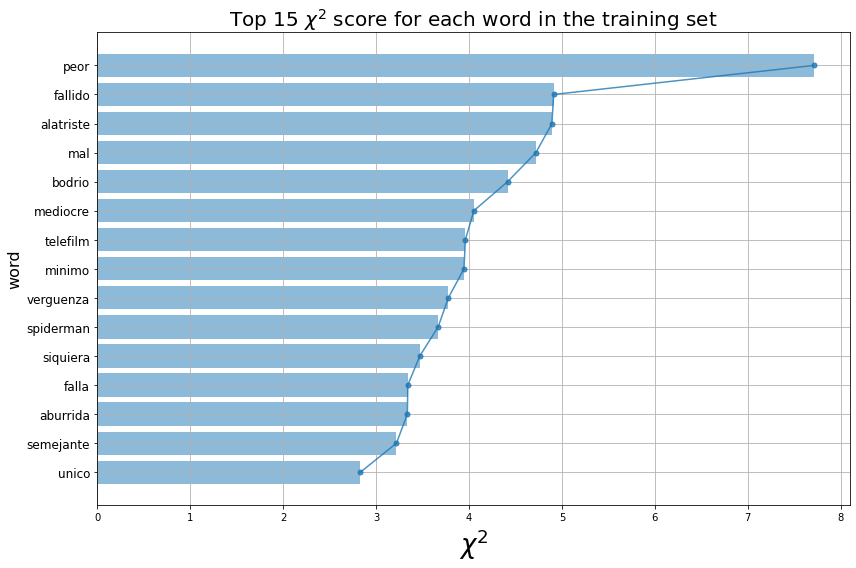

In [ ]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

# Entrenamiento


Para este apartado empelaremos un modelo que es  adecuado para tareas de clasificación binaria con variables discretas. La aproximación será simple en el sentido de que no se destinarán esfuerzos al tuning de hiperparametros.

In [ ]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.6597938144329897
Accuracy for C=0.05: 0.6597938144329897
Accuracy for C=0.25: 0.6701030927835051
Accuracy for C=0.5: 0.7010309278350515
Accuracy for C=1: 0.7402061855670103
Accuracy for C=10: 0.7536082474226804
Accuracy for C=100: 0.7329896907216494
Accuracy for C=1000: 0.7381443298969073
Accuracy for C=10000: 0.7412371134020619


# Algunas métricas

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[516 124]
 [127 203]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       640
           1       0.62      0.62      0.62       330

    accuracy                           0.74       970
   macro avg       0.71      0.71      0.71       970
weighted avg       0.74      0.74      0.74       970

Accuracy score:0.7412371134020619


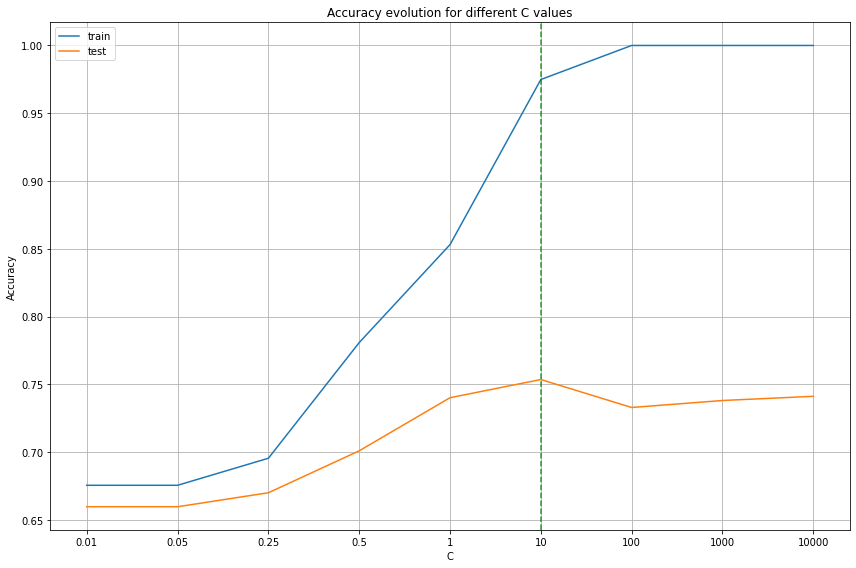

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, test_predict)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

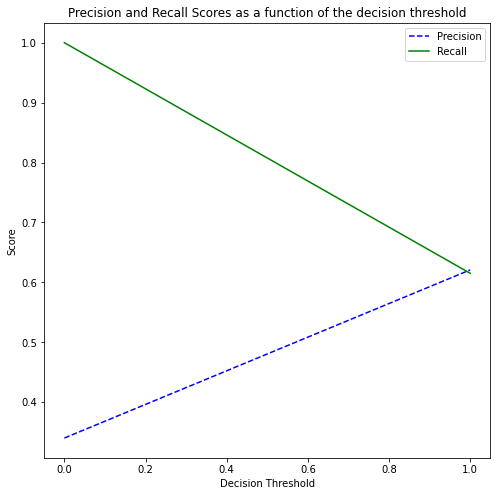

In [ ]:
plot_precision_recall_vs_threshold(p, r, thresholds)

# Predict

In [ ]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['review']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [ ]:
for i in random.sample(range(0, len(df)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 3557
Actual sentiment: 1
Prediction: [1]

Review no. 355
Actual sentiment: 1
Prediction: [1]

Review no. 893
Actual sentiment: 0
Prediction: [0]

Review no. 240
Actual sentiment: 1
Prediction: [1]

Review no. 5
Actual sentiment: 1
Prediction: [1]


# Plus

## Vader 

Es una libreria de procesamiento de Lenguaje Natural proporciona tareas comunes de procesamiento de lenguaje natural (PNL) tales como análisis de sentimiento

In [32]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 3.9 MB/s eta 0:00:00


In [33]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
analyzer = SentimentIntensityAnalyzer()
for row in df:
    vs = analyzer.polarity_scores(df)

¿Que significa estos resultados de VADER?

* neu=neutral
* compound= es una regla que normaliza, digamos que puede ser parecido a una media de los otros valores
* pos=positivo
* neg=negativo


En general podemos decir:

* ositivo sentimiento: compound >= 0.5
* neutral sentimiento: (compound > -0.5) and (compound < 0.5)
* negativo sentimiento: compound <= -0.5


In [35]:
# Calculamos los 4 scores para cada review y las guardamos como features en el dataframe
df['vader_neg_t'] = 0
df['vader_pos_t'] = 0
df['vader_neu_t'] = 0
df['vader_compound_t'] = 0

In [36]:
for i, q in enumerate(df['review'].values):
    vs = analyzer.polarity_scores(q)
    df.iloc[i, -4] = vs['neg']
    df.iloc[i, -3] = vs['pos']
    df.iloc[i, -2] = vs['neu']
    df.iloc[i, -1] = vs['compound']
  

In [37]:
# PROCESAMIENTO DEL TEXTO
SP_STOP_WORDS = ["pelicula","telefilm"]
custom_stop_words = list(SP_STOP_WORDS)

# Usamos  TfidfVectorizer para transformar y quitando las stopwords. 
# With TfidfVectorizer, palabras comunes son penalizadas y palabras raras tienen mucha influencia 
vectorizer = TfidfVectorizer(stop_words=custom_stop_words)

X = vectorizer.fit_transform(df['review']) 

In [ ]:
X.todense().tolist()
a = zip(vectorizer.get_feature_names(),X.sum(axis=0).tolist()[0])

In [ ]:
df.head()

In [ ]:
df.sort_values('vader_neg_t', ascending=False, inplace=True)
for i in range(10):
    print (df[['review','sentiment']].values[i])

In [ ]:
df.sort_values('vader_pos_t', ascending=False, inplace=True)
for i in range(10):
    print (df.review.values[i])